## Loan probability of default  -  Explain the model with SHAP values
### Nata Berishvili

* Libraries, data preparation
* random forest
* Model interpretability
- The summary_plot
- The dependence_plot
- The force_plot for 4 individual observations
* Conclusion

####For this project I will specifically focus on Model interpretability and less on feature engineering and the actual modeling. The computation time increases exponentially with the number of features, so I will use the small dataset and limit the number of variables.  The main purpose  is to explain the model with SHAP values. (I still need to prepare data - Scikit-learn decision tree methods need appropriate variable transformation including missing imputation, one hot encoding for categorical variables, etc)

####Some models are easy to interpret such as linear / logistic regression (weight on each feature, knowing the exact contribution and negative and positive interaction), single decision trees, some models are harder to interpret such as Ensemble models - it is hard to understand the role of each feature, it comes with "feature importance" but does not tell if feature affects decision positively or negatively

####The Shapley value is the average of all the marginal contributions to all possible coalitions. If we estimate the Shapley values for all feature values, we get the complete distribution of the prediction (minus the average) among the feature values.The interpretation of the Shapley value for feature value j is: The value of the j-th feature contributed ϕj to the prediction of this particular instance compared to the average prediction for the dataset.

In [581]:
import numpy as np
import seaborn as sns
import datetime
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost.sklearn import XGBClassifier
import shap
shap.initjs()
from sklearn.preprocessing import Imputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [582]:
df = pd.read_csv("loandefault.csv")

In [583]:
df = df.sample(frac =.3)

####To limit the numer of variables, I will use H2O random forest pre-select variables.

In [584]:
df = df[['loan_default','TD009', 'TD010', 'TD013','TD014', 'TD001', 'AP001', 'CR018', 'CR019', 'MB005', 'PA029', 'AP004', 'AP003', 'CR015', 'CD117', 'CD118']] #,  'CR009','TD013', 'TD014', 'CR017', 'TD006', 

In [108]:
#df.dtypes

####I will clean the dataset, from missing values and -99, -98 which do not make sence for these specific columns.

In [585]:
df['PA029'].replace(-99, 0, inplace= True) #np.nan IN 0
df['PA029'].replace(-98, 0, inplace= True) #np.nan IN 0
df['CD117'].replace(-99, 0, inplace= True) #np.nan IN 0
df['CD117'].replace(-98, 0, inplace= True) #np.nan IN 0
df['CD118'].replace(-99, 0, inplace= True) #np.nan IN 0
df['CD118'].replace(-98, 0, inplace= True) #np.nan IN 0

In [586]:
df.isnull().sum().sum()

1134

###replace missing values with mean of that column

In [587]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [144]:
#df.isnull().sum()

In [590]:
list(df.columns)

['loan_default',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD001',
 'AP001',
 'CR018',
 'CR019',
 'MB005',
 'PA029',
 'AP004',
 'AP003',
 'CR015',
 'CD117',
 'CD118']

In [591]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

In [592]:
Y = df['loan_default']
X =  df[['TD009', 'TD010', 'TD013', 'TD014', 'TD001', 'AP001', 'CR018', 'CR019', 'MB005', 'PA029', 'AP004', 'AP003', 'CR015', 'CD117', 'CD118']]

In [594]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

####XGboost classifier

In [393]:
#from xgboost import XGBClassifier
#model = XGBClassifier()
#model.fit(X_train, Y_train)
#print(model.feature_importances_)
#predict_train = model.predict(X_train)

####Random Forest classifier

In [556]:
#model = RandomForestClassifier(n_estimators=12, class_weight="balanced", random_state=8)
#model.fit(X_train, Y_train)
#print(model.feature_importances_)

####Random Forest regressor

In [595]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  
print(model.feature_importances_)

[0.08442755 0.03208074 0.20537004 0.02961138 0.04414385 0.04224044
 0.01566212 0.01564478 0.05557432 0.07034079 0.1360724  0.14455727
 0.04661479 0.04243276 0.03522674]


In [596]:
importances = model.feature_importances_
indices = np.argsort(importances)

####If we look at the feature importances returned by out model we see that TD013 dominates the other features, clearly standing out as the most important predictor of loan_default, followed by AP003, AP004, etc. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance, and in sklearn rf classifier it averages over all all DecisionTreeClassifer's feature_importances_ attributes in the ensemble.

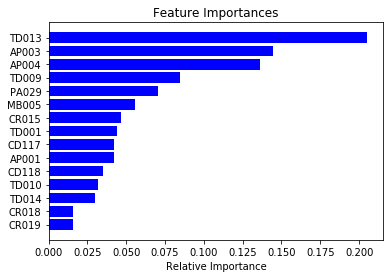

In [597]:
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

####Some models are easy to interpret such as linear / logistic regression (weight on each feature, knowing the exact contribution and negative and positive interaction), single decision trees, some models are harder to interpret such as Ensemble models - it is hard to understand the role of each feature, it comes with "feature importance" but does not tell if feature affects decision positively or negatively

####The Shapley value is the average of all the marginal contributions to all possible coalitions. If we estimate the Shapley values for all feature values, we get the complete distribution of the prediction (minus the average) among the feature values.The interpretation of the Shapley value for feature value j is: The value of the j-th feature contributed ϕj to the prediction of this particular instance compared to the average prediction for the dataset.


In [598]:
import shap
shap.initjs()

In [599]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)

In [600]:
# Determine the correlation in order to plot with different colors
corrlist = np.zeros( len(features))
X_train_np = X_train.to_numpy() # our X_train is a pandas data frame. Convert it to numpy
for i in range(0,len(features) ):
    tmp = np.corrcoef(shap_values[:,i],X_train_np[:,i])
    corrlist[i] = tmp[0][1]
# plot it
shap_v_abs = np.abs(shap_values) # Get the absolute values of all SHAP values

    

####SHAP Summary PloT explains marginal output of the model, We can see below that the primary risk  for mortgage loan defaul according to the model is AP003 (the education) variable, followed by TD013, AP004, etc.

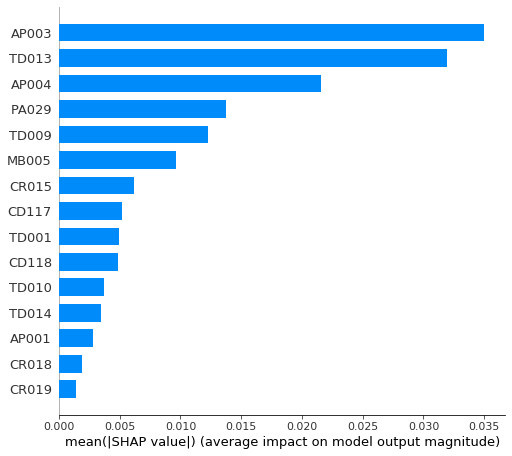

In [601]:
shap.summary_plot(shap_values, X, plot_type="bar")

####As we can see importance of the variables in RF importance plot and SHAP summary plot are different: Permutation feature importance is based on the decrease in model performance, while SHAP is based on magnitude of feature attributions.

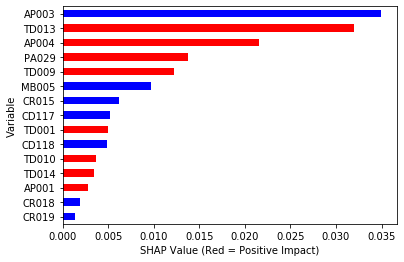

In [602]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(6,4),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)  

####The next is the density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. By plotting the impact of a feature on every sample we can also see important outlier effects. 


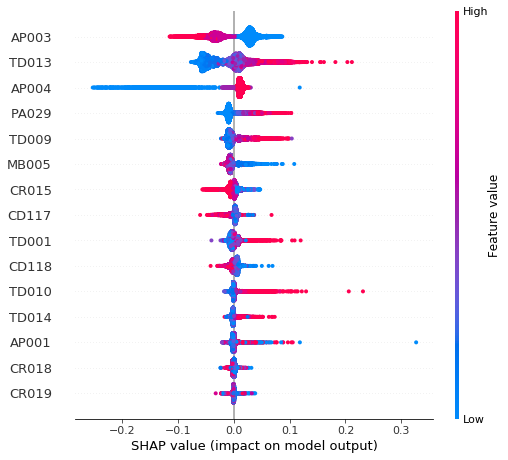

In [604]:
shap.summary_plot(shap_values, X_train)

####SHAP dependence plots show the effect of a single feature across the whole dataset (another feature is chosen for coloring to highlight possible interactions).

####AP003 is the most significant variable and is negatively correlated with the loan_default - means the higher the level of education the lower is the chance of loan default.

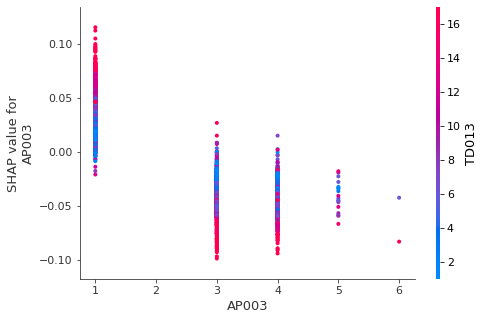

In [532]:
shap.dependence_plot("AP003", shap_values, X_train)

#####The following plot shows there is an approximately linear and positive trend between “TD013” and the target variable, and “TD013” interacts with “AP003” frequently.

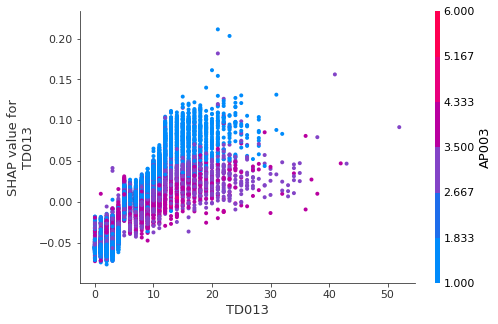

In [605]:
shap.dependence_plot("TD013", shap_values, X_train)

####AP004 has the positive correlation with loan default. the higher the loan term period the higher is the probability of default.

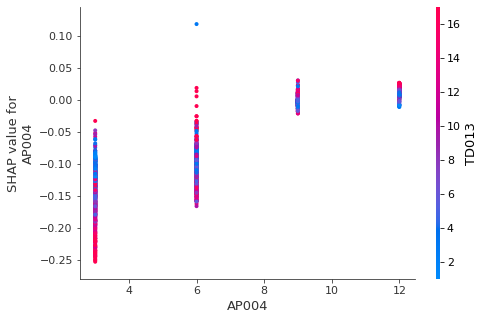

In [606]:
shap.dependence_plot("AP004", shap_values, X_train)

####PA029 COLLECTION_OR_HIGH_RISK_calls - it shows positive trend between “PA029” and the target variable, and “PA029” interacts with “AP003” frequently. That means the higher the collection calls the higher is the chance of loan_default. 
(plot woult look better without those outliers)

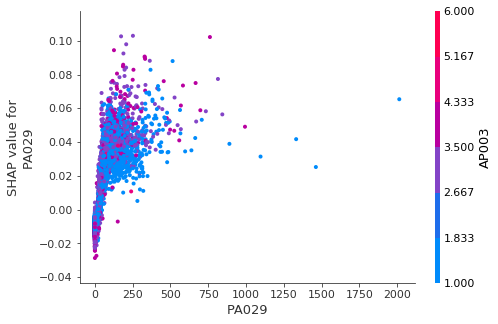

In [607]:
shap.dependence_plot("PA029", shap_values, X_train)

####SHAP Interaction Value Summary Plot -  we can see interaction values for top variables. (500 observation)

In [610]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:500,:])

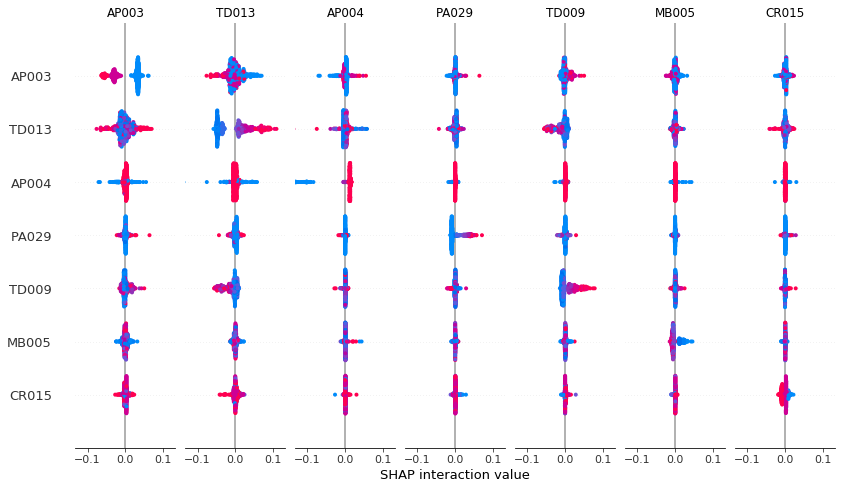

In [609]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:500,:])
shap.summary_plot(shap_interaction_values, X_train.iloc[:500,:])

In [611]:
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

random_picks = np.arange(5)
S = X_output.iloc[random_picks] #I will print this table laterm few lines below next to the plots

In [612]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [613]:
X_train.mean()

TD009      5.385000
TD010      2.023988
TD013      6.768095
TD014      2.596250
TD001      1.998036
AP001     31.657083
CR018      4.357143
CR019      6.220060
MB005      5.983429
PA029     25.194989
AP004     11.259464
AP003      2.008571
CR015      4.929167
CD117     52.179212
CD118    119.410880
dtype: float64

####This is the base value E[f(z)] that would be predicted if we did not know any features to the current output
f(x). 

In [614]:
Y_test.mean()

0.19236111111111112

In [542]:
S #5 observations 

TD009  TD010  TD013  TD014  TD001  AP001  CR018  CR019  MB005  PA029  \
2087      17      9     14      9      6     26      3      6    5.0    0.0   
79030      2      0      0      0      0     26      3      5    2.0    0.0   
33346      4      1      9      2      0     26      1      3   10.0  166.0   
61491      3      1      3      1      0     38      8     12    8.0    0.0   
57618     16      5     17      6      3     27      1      3    4.0    0.0   

       AP004  AP003  CR015  CD117  CD118  predict  
2087      12      4      3    0.0    0.0     0.33  
79030     12      3      3   17.0   29.0     0.11  
33346      3      1      3   79.0  162.0     0.27  
61491     12      1      6  114.0  227.0     0.07  
57618     12      3      2   52.0  102.0     0.17

The following graphs show the interpretation of the prediction.
- Output value: is the prediction for that observation.
- Base value - defined earlier
- Features that pushed away to the right or left the prediction.

####The output value is the prediction for that observation IS 0.33. (base value 0.1855)
The first graphs corespons to the first prediction 0.33 is S table above, We can see that the CR015=3, TD001=6, CD117=0..push prediction to the right, while AP003 = 4, PA029 = 0...to the left.

In [543]:
shap_plot(0)

####We can see from the plot that:
- AP003 = 1 (lowest education level) and AP004 = 12 (longer loan term period) is moving our prediction higher to the right from the base value. ("Pushing to predict the loan default" - Has the negative impact in our case)
- PA029 = 0 and TD009 =4 is moving our prediction lower to the left (has the positive impact)

In [615]:
shap_plot(1)

####The output value is the prediction for that observation IS 0.27.
- PA029 = 166 (collection^high risk calls) pushing prediction to the right, AP004 the short term loan pushing prediction lower to the left.

In [545]:
shap_plot(2)

####Logically TD013 AND TD009 high number of queries P2P pushing prediction higher to the right.

In [546]:
shap_plot(4)

####The above explanation shows features each contributing to push the model output from the base value,Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue, If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [547]:
shap.force_plot(explainer.expected_value, shap_values, X)

SUMMARY - The importance of the variables identified by "black box" model and SHAP  are different, SHAP is based on magnitude of feature attributions. Besides of  "feature importance" it  does tell if feature affects decision positively or negatively.
The most important features identified by SHAP are : AP003, TD013, AP004 and PA029. Which suggests that - Observations with high probability of default, are associated with low education level, high loan_term, high number of collection/calls, and the number of queries P2P/SMALL LOAN.